### Import niezbędnych bibliotek

In [1]:
!pip install catboost
!pip install WordCloud
!pip install cleantext

  Using cached wordcloud-1.8.1.tar.gz (220 kB)
  Running setup.py clean for WordCloud
Failed to build WordCloud

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Kasia\anaconda3\envs\sda\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Kasia\\AppData\\Local\\Temp\\pip-install-0eu9xynf\\wordcloud_dac4f8b9affe4bb49b45f4063087e42a\\setup.py'"'"'; __file__='"'"'C:\\Users\\Kasia\\AppData\\Local\\Temp\\pip-install-0eu9xynf\\wordcloud_dac4f8b9affe4bb49b45f4063087e42a\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Kasia\AppData\Local\Temp\pip-wheel-4jn58cua'
       cwd: C:\Users\Kasia\AppData\Local\Temp\pip-install-0eu9xynf\wordcloud_dac4f8b9affe4bb49b45f4063087e42a\
  Complete output (20 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-


    Running setup.py install for WordCloud: started
    Running setup.py install for WordCloud: finished with status 'error'


In [2]:
import pandas as pd
import numpy as np
import spacy
import re
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
from cleantext import clean as clean_text
import seaborn as sns

!python -m spacy download pl_core_news_sm

2022-06-23 20:21:32.979478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-06-23 20:21:32.979546: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[+] Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')


### Analiza i czyszczenie danych

In [3]:
def de_emojify(text):
    regex_pattern = re.compile(pattern="["
                                       u"\U0001F600-\U0001F64F"
                                       u"\U0001F300-\U0001F5FF"
                                       u"\U0001F680-\U0001F6FF"
                                       u"\U0001F1E0-\U0001F1FF"
                                       "]+", flags=re.UNICODE)
    return regex_pattern.sub(r'', text).strip()


def de_emojify2(text):
    return clean_text(text, no_emoji=True)


def clear_opinions_df(
        df: pd.DataFrame, opinion_label: str, punctuation=True, new_lines=True,
        emojis=True, lower=True, drop_duplicates=True, drop_na=True):
    
    if punctuation:
        df[opinion_label] = df.apply(lambda x: ' '.join(re.findall('[^!,.;:*()+-/"? ]+', str(x[opinion_label]))), axis=1)

    if new_lines:
        df[opinion_label] = df.apply(lambda x: str(x[opinion_label]).replace("\r", "").replace("\n", ""), axis=1)

    if emojis:
        df[opinion_label] = df[opinion_label].apply(de_emojify)

    if lower:
        df[opinion_label] = df[opinion_label].str.lower()

    if drop_duplicates:
        df.drop_duplicates(inplace=True)

    if drop_na:
        df.dropna(inplace=True)

    return df

In [4]:
df = pd.read_csv("Crawl/data_all.csv")
print(df.info(),"\n", df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196213 entries, 0 to 196212
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Opinion  194725 non-null  object
 1   Score    194725 non-null  object
 2   URL      194725 non-null  object
dtypes: object(3)
memory usage: 4.5+ MB
None 
                                         Opinion Score  \
0  Rzadko spotykany obecnie ekran 5,3" - zaleta     4   
1                        Porządne  wykonanie.       5   
2                 Towar zgodny z oczekiwaniami.     5   
3                          bardzo dobry telefon     5   
4                         Bardzo dobry produkt.     5   

                                       URL  
0  https://www.ceneo.pl/104775223/opinie-2  
1  https://www.ceneo.pl/104775223/opinie-2  
2  https://www.ceneo.pl/104775223/opinie-2  
3  https://www.ceneo.pl/104775223/opinie-2  
4  https://www.ceneo.pl/104775223/opinie-2  


In [5]:
# df zawierający URLe zostawiamy na koniec - posłuży do zaprezentowania możliwości prezentacji
# analizy tematów dla konkretnych produktów
df_urls = df[["URL", "Opinion", "Score"]]

In [6]:
df = df[["Opinion", "Score"]]

In [7]:
cleared_df = clear_opinions_df(df=df, opinion_label="Opinion")

In [8]:
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px


fig = px.histogram(cleared_df, x="Score").update_xaxes(categoryorder = "total ascending")
fig.update_traces(marker_color="green",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Liczba opinii a ocena', title_x=0.5)
fig.show()

In [9]:
cleared_df.head(10)

Opinion Score
0   rzadko spotykany obecnie ekran 5 3 zaleta     4
1                          porządne wykonanie     5
2                towar zgodny z oczekiwaniami     5
3                        bardzo dobry telefon     5
4                        bardzo dobry produkt     5
6                 trochę się długo zastanawia   3,5
7                  na razie jestem zadowolony     4
8                    wszystko zgodne z opisem     5
10                          właściwa wielkość     5
11                          jestem zadowolony   4,5

In [10]:
def convert_score_to_floats(df:pd.DataFrame, score_label: str) -> pd.DataFrame:
    df[score_label] = df[score_label].apply(lambda x: float(x.replace(",", ".")))
    return df

In [11]:
df = convert_score_to_floats(df=cleared_df, score_label="Score")

In [12]:
def clear_numeric_only_opinions(df:pd.DataFrame, opinion_label: str) -> pd.DataFrame:
    df["Is numeric"] = df[opinion_label].apply(lambda x: x.isnumeric())
    df = df[df["Is numeric"] == False]
    df.drop(columns=["Is numeric"], inplace=True)
    return df

In [13]:
df = clear_numeric_only_opinions(df=df, opinion_label="Opinion")

C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/3450323415.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
def get_sentiment_df(df: pd.DataFrame, score_label: str, negative_border=2.5, positive_border = 4, drop_score_label=True) -> pd.DataFrame:

    df = df[(df[score_label] <= negative_border) | (df[score_label] >= positive_border)]
    df["Sentiment"] = df[score_label].apply(lambda x: 1 if x >= positive_border else 0)

    if drop_score_label:
        df.drop(columns=[score_label], inplace=True)

    return df

In [15]:
sentiment_df = get_sentiment_df(df=df, score_label="Score", drop_score_label=False)
sentiment_df

C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/4230755856.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Opinion  Score  Sentiment
0       rzadko spotykany obecnie ekran 5 3 zaleta    4.0          1
1                              porządne wykonanie    5.0          1
2                    towar zgodny z oczekiwaniami    5.0          1
3                            bardzo dobry telefon    5.0          1
4                            bardzo dobry produkt    5.0          1
...                                           ...    ...        ...
196083              produkt oceniam bardzo dobrze    5.0          1
196084              iphone to jakość sama w sobie    5.0          1
196085                wszystko ok świetny telefon    5.0          1
196086                    to samo co o poprzednim    5.0          1
196092                     jest warty swojej ceny    4.5          1

[25302 rows x 3 columns]

In [16]:
sentiment_df.to_csv("input_data.csv", index=False)

In [17]:
print("Ilość wierszy w tabeli wynosi {}, liczba recenzji z pozytywnym sentymentem to {}, z negatywnym:{}. \nDane są NIEZBALANSOWANE.".format(len(sentiment_df),len(sentiment_df[sentiment_df["Sentiment"] == 1]),len(sentiment_df[sentiment_df["Sentiment"] == 0])))

Ilość wierszy w tabeli wynosi 25302, liczba recenzji z pozytywnym sentymentem to 24078, z negatywnym:1224. 
Dane są NIEZBALANSOWANE.


#### Balansowanie danych
poprzez undersampling - liczba próbek dla każdego z sentymentów będzie równa

In [18]:
def get_balanced_df(df, ground_truth_label, shuffle=True):
    ground_truths = list(df[ground_truth_label].unique())
    rows_per_ground_truth = df[df[ground_truth_label] == ground_truths[0]].shape[0]

    for ground_truth in ground_truths:
        if rows_per_ground_truth > df[df[ground_truth_label] == ground_truth].shape[0]:
            rows_per_ground_truth = df[df[ground_truth_label] == ground_truth].shape[0]

    dfs = []
    for ground_truth in ground_truths:
        temp_df = df[df[ground_truth_label] == ground_truth].sample(frac=1, random_state = 12).reset_index(drop=True).head(rows_per_ground_truth)
        dfs.append(temp_df)

    result = pd.concat(dfs).reset_index(drop=True)

    if shuffle:
        return result.sample(frac=1).reset_index(drop=True)
    else:
        return result

In [19]:
balanced_df = get_balanced_df(df=sentiment_df, ground_truth_label="Sentiment")
balanced_df

Opinion  Score  Sentiment
0                        super produkt wygląd i funkcje    5.0          1
1     na moje potrzeby super telefon nic wiecej nie ...    5.0          1
2     przereklamowane egzemplarz z rozlanym klejem p...    0.5          0
3     katastrofa zachęcony poprzednikiem postanowiłe...    0.5          0
4                   odpowiem jak dostanę go od mikołaja    4.0          1
...                                                 ...    ...        ...
2443  mojego iphone 6 w wersji 64gb w kolorze srebrn...    4.5          1
2444                            to jest wersja dual sim    2.5          0
2445                 brak ładowarki powinien być karany    5.0          1
2446  bardzo wydajny telefon do użytku służbowego re...    5.0          1
2447  telefon mi się zacina przy kilku aplikacjach w...    2.5          0

[2448 rows x 3 columns]

### Analiza sentymentu

In [20]:
nlp = spacy.load("pl_core_news_sm")

#### Lematyzacja opinii

In [21]:
def lemmatizer(nlp_model, df):
    doc = nlp_model(
        str(df["Opinion"]))
    result = ""
    for token in doc:
        result += f"{token.lemma_} "
    return result[:-1]

def prepare_input_phrases_with_lemmas(nlp_model, df):
    df['Lemma'] = df.apply(partial(lemmatizer, nlp_model), axis=1)
    print("Stworzono df z frazami lemma.")

    return df

In [22]:
balanced_df_with_lemmas = prepare_input_phrases_with_lemmas(nlp, balanced_df)

Stworzono df z frazami lemma.


In [23]:
balanced_df_with_lemmas.to_csv("lemmatized_opinions.csv", index=False)
balanced_df_with_lemmas.head()

Opinion  Score  Sentiment  \
0                     super produkt wygląd i funkcje    5.0          1   
1  na moje potrzeby super telefon nic wiecej nie ...    5.0          1   
2  przereklamowane egzemplarz z rozlanym klejem p...    0.5          0   
3  katastrofa zachęcony poprzednikiem postanowiłe...    0.5          0   
4                odpowiem jak dostanę go od mikołaja    4.0          1   

                                               Lemma  
0                     super produkt wygląd i funkcja  
1  na mój potrzeba super telefon nic wiecej nie p...  
2  przereklamowane egzemplarz z rozlać klejem pod...  
3  katastrofa zachęcć poprzednikie postanowić być...  
4              odpowiedzieć jak dostać on od mikołaj

In [24]:
df = balanced_df_with_lemmas[["Lemma", "Score", "Sentiment"]].rename(columns = {"Lemma": "Opinion"})
df.head()

Opinion  Score  Sentiment
0                     super produkt wygląd i funkcja    5.0          1
1  na mój potrzeba super telefon nic wiecej nie p...    5.0          1
2  przereklamowane egzemplarz z rozlać klejem pod...    0.5          0
3  katastrofa zachęcć poprzednikie postanowić być...    0.5          0
4              odpowiedzieć jak dostać on od mikołaj    4.0          1

#### Wyznaczanie X, y oraz podział na zbiory trenujący i testowy

In [25]:
X=df['Opinion'].values
y=df['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 42)

print(X.shape, y.shape,"\n",X_train.shape, y_train.shape,"\n",X_test.shape, y_test.shape )

(2448,) (2448,) 
 (1958,) (1958,) 
 (490,) (490,)


#### Wektoryzacja X - feature extraction

In [26]:
vec = CountVectorizer()
vec.fit(X_train)
X_train_cv = vec.transform(X_train)
X_test_cv = vec.transform(X_test)

#### Podejście #1 do analizy sentymentu - model sekwencyjny

In [27]:
dl_model = Sequential()
dl_model.add(Dense(16, input_dim=X_train_cv.shape[1], activation='relu'))
dl_model.add(Dense(16, activation='relu'))
dl_model.add(Dense(1, activation='sigmoid'))
dl_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics="accuracy")

In [28]:
sentiment_model_cv = dl_model.fit(X_train_cv, y_train, batch_size=64, epochs=20, verbose=1)

Epoch 1/20


C:\Users\Kasia\anaconda3\envs\sda\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning:

Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.



31/31 [==============================] - 2s 4ms/step - loss: 0.6514 - accuracy: 0.6885
Epoch 2/20
31/31 [==============================] - 0s 4ms/step - loss: 0.5279 - accuracy: 0.8381
Epoch 3/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3786 - accuracy: 0.8871
Epoch 4/20
31/31 [==============================] - 0s 4ms/step - loss: 0.2646 - accuracy: 0.9326
Epoch 5/20
31/31 [==============================] - 0s 4ms/step - loss: 0.1914 - accuracy: 0.9561
Epoch 6/20
31/31 [==============================] - 0s 6ms/step - loss: 0.1441 - accuracy: 0.9688
Epoch 7/20
31/31 [==============================] - 0s 7ms/step - loss: 0.1112 - accuracy: 0.9770
Epoch 8/20
31/31 [==============================] - 0s 6ms/step - loss: 0.0882 - accuracy: 0.9862
Epoch 9/20
31/31 [==============================] - 0s 5ms/step - loss: 0.0722 - accuracy: 0.9883
Epoch 10/20
31/31 [==============================] - 0s 4ms/step - loss: 0.0611 - accuracy: 0.9893
Epoch 11/20
31/31 [===========

Komentarz: Tak wysoka wartość accuracy może świadczyć o przetrenowaniu modelu. Model być może źle poradził sobie z tak małą próbką danych.

#### Podejście #2 do analizy sentymentu - regresja logistyczna

In [29]:
# tworzymy funkcję do oceny modelu

def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')
    
def plot_confusion_matrix(confusion_matrix, classes, title=None,
                          title_appendix='',
                          cmap=plt.cm.Blues):
    # tytuł wykresu
    if title_appendix:
        title_appendix = f'({title_appendix})'
    if title is None:
        title = f'Confusion matrix {title_appendix}'
    
    fig, ax = plt.subplots()
    # rysuje CM
    img = ax.imshow(confusion_matrix, cmap=cmap)
    # dodaje pasek z boku
    ax.figure.colorbar(img, ax=ax)
    # dodatki do wykresu
    ax.set_xticks(np.arange(confusion_matrix.shape[1]))
    ax.set_xticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    # etykiety
    fmt = '.2f' if confusion_matrix.dtype == 'float' else 'd'
    thresh = confusion_matrix.max() / 2
    for y, row in enumerate(confusion_matrix):
        for x, cell in enumerate(row):
            ax.text(x, y, format(cell, fmt),
                    ha='center', va='center',
                    color='white' if cell > thresh else 'black')
    fig.tight_layout()
    
    return ax

Trenujący:
Results for LogisticRegression
----
  Accuracy:  0.9759959141981613
  Precision: 0.9761394851756298
  Recall:    0.9759959141981613
  F1 score:  0.9759941045657008
  Mislabeled 47 out of 1958


Testowy:
Results for LogisticRegression
----
  Accuracy:  0.8408163265306122
  Precision: 0.8416359112239274
  Recall:    0.8408163265306123
  F1 score:  0.8407207988131158
  Mislabeled 78 out of 490




<AxesSubplot:title={'center':'Confusion matrix '}, xlabel='Predicted label', ylabel='True label'>

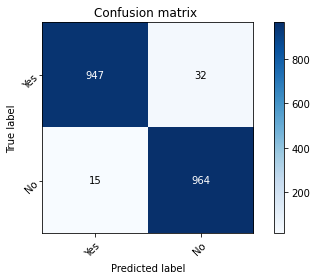

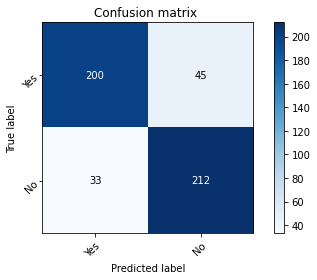

In [30]:
lr_model = LogisticRegression()

lr_model.fit(X_train_cv, y_train)
y_lr_pred_train = lr_model.predict(X_train_cv)
y_lr_pred = lr_model.predict(X_test_cv)

print("Trenujący:")
print_results(calculate_metrics(y_train, y_lr_pred_train), 'LogisticRegression')
cm = confusion_matrix(y_train, y_lr_pred_train)
plot_confusion_matrix(cm, ["Yes", "No"])

print("Testowy:")
print_results(calculate_metrics(y_test, y_lr_pred), 'LogisticRegression')
cm = confusion_matrix(y_test, y_lr_pred)
plot_confusion_matrix(cm, ["Yes", "No"])

Komentarz: Duża różnica accuracy między modelem treningowym a testowym świadczy o przetrenowaniu modelu. Sprawdźmy jeszcze jak model radzi sobie w określeniu sentymentu dla fraz testowych:

#### Podejście #3 do analizy sentymentu - zespoły klasyfikatorów:  Adaboost

Best CV params {'learning_rate': 1, 'n_estimators': 100}
Trenujący:
Results for AdaBoost
----
  Accuracy:  0.8549540347293156
  Precision: 0.8593269587241769
  Recall:    0.8549540347293156
  F1 score:  0.8545113942597002
  Mislabeled 284 out of 1958


Testowy:
Results for AdaBoost
----
  Accuracy:  0.8040816326530612
  Precision: 0.810052829163057
  Recall:    0.8040816326530613
  F1 score:  0.8031337886701486
  Mislabeled 96 out of 490




<AxesSubplot:title={'center':'Confusion matrix '}, xlabel='Predicted label', ylabel='True label'>

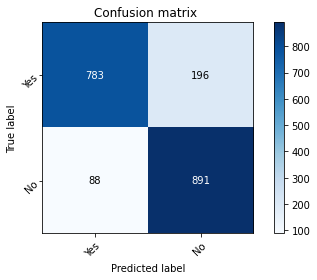

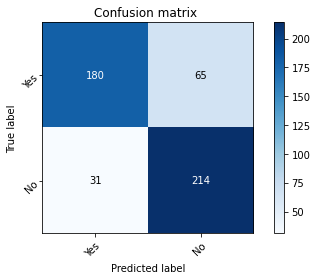

In [31]:
boost = AdaBoostClassifier()
searcher_boost = GridSearchCV(boost, {'n_estimators':[30, 50, 100], 'learning_rate':[1, 2]})
searcher_boost.fit(X_train_cv, y_train)
print("Best CV params", searcher_boost.best_params_)

y_pred_train_boost = searcher_boost.predict(X_train_cv)
y_pred_boost = searcher_boost.predict(X_test_cv)

print("Trenujący:")
print_results(calculate_metrics(y_train, y_pred_train_boost), 'AdaBoost')
cm = confusion_matrix(y_train, y_pred_train_boost)
plot_confusion_matrix(cm, ["Yes", "No"])

print("Testowy:")
print_results(calculate_metrics(y_test, y_pred_boost), 'AdaBoost')
cm = confusion_matrix(y_test, y_pred_boost)
plot_confusion_matrix(cm, ["Yes", "No"])

Komentarz: Nastąpiło przetrenowanie modelu

#### Podejście #4 do analizy sentymentu - catboost

0:	learn: 0.6217245	total: 163ms	remaining: 2.29s
1:	learn: 0.6015517	total: 176ms	remaining: 1.14s
2:	learn: 0.5764506	total: 186ms	remaining: 743ms
3:	learn: 0.5623395	total: 197ms	remaining: 542ms
4:	learn: 0.5487840	total: 213ms	remaining: 427ms
5:	learn: 0.5353418	total: 226ms	remaining: 339ms
6:	learn: 0.5255957	total: 238ms	remaining: 272ms
7:	learn: 0.5150403	total: 253ms	remaining: 221ms
8:	learn: 0.5063938	total: 273ms	remaining: 182ms
9:	learn: 0.4964516	total: 291ms	remaining: 145ms
10:	learn: 0.4888248	total: 303ms	remaining: 110ms
11:	learn: 0.4826720	total: 316ms	remaining: 79ms
12:	learn: 0.4758531	total: 329ms	remaining: 50.6ms
13:	learn: 0.4719804	total: 341ms	remaining: 24.3ms
14:	learn: 0.4692305	total: 353ms	remaining: 0us
Trenujący:
Results for CatBoost
----
  Accuracy:  0.7594484167517875
  Precision: 0.7706303600191546
  Recall:    0.7594484167517875
  F1 score:  0.7569376961400973
  Mislabeled 471 out of 1958


Testowy:
Results for CatBoost
----
  Accuracy:  0.

<AxesSubplot:title={'center':'Confusion matrix '}, xlabel='Predicted label', ylabel='True label'>

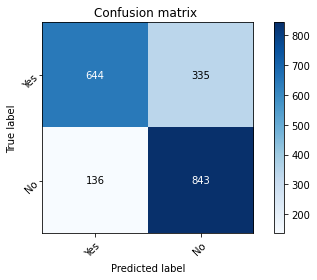

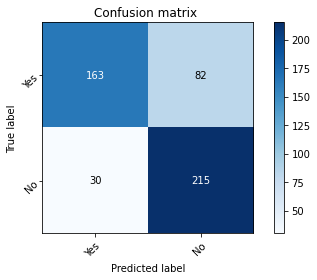

In [32]:
cat_features = [0, 1]

catboost_model = CatBoostClassifier(iterations=15,
                                    learning_rate=1,
                                    depth=1, 
                                    random_seed = 42)     

catboost_model.fit(X_train_cv, y_train, cat_features)

y_pred_train_catboost = catboost_model.predict(X_train_cv)
y_pred_catboost = catboost_model.predict(X_test_cv)


print("Trenujący:")
print_results(calculate_metrics(y_train, y_pred_train_catboost), 'CatBoost')
cm = confusion_matrix(y_train, y_pred_train_catboost)
plot_confusion_matrix(cm, ["Yes", "No"])

print("Testowy:")
print_results(calculate_metrics(y_test, y_pred_catboost), 'CatBoost')
cm = confusion_matrix(y_test, y_pred_catboost)
plot_confusion_matrix(cm, ["Yes", "No"])

#### Podejście #5 do analizy sentymentu - LinearSVC

Trenujący:
Results for LinearSVC
----
  Accuracy:  0.9923391215526047
  Precision: 0.9923642935249877
  Recall:    0.9923391215526047
  F1 score:  0.9923390236363423
  Mislabeled 15 out of 1958


Testowy:
Results for LinearSVC
----
  Accuracy:  0.8122448979591836
  Precision: 0.8127659574468085
  Recall:    0.8122448979591836
  F1 score:  0.8121666666666667
  Mislabeled 92 out of 490




<AxesSubplot:title={'center':'Confusion matrix '}, xlabel='Predicted label', ylabel='True label'>

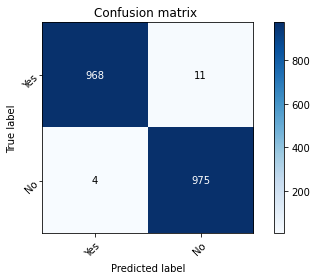

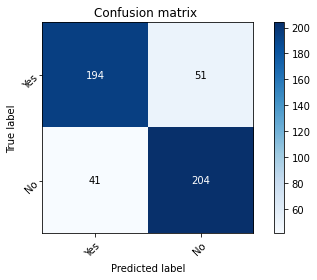

In [33]:
LSVC = LinearSVC()

LSVC.fit(X_train_cv, y_train)

y_pred_train_lsvc = LSVC.predict(X_train_cv)
y_pred_lsvc = LSVC.predict(X_test_cv)

print("Trenujący:")
print_results(calculate_metrics(y_train, y_pred_train_lsvc), 'LinearSVC')
cm = confusion_matrix(y_train, y_pred_train_lsvc)
plot_confusion_matrix(cm, ["Yes", "No"])

print("Testowy:")
print_results(calculate_metrics(y_test, y_pred_lsvc), 'LinearSVC')
cm = confusion_matrix(y_test, y_pred_lsvc)
plot_confusion_matrix(cm, ["Yes", "No"])

Tu również doszło do przetrenowania modelu.

Najlepsze rezultaty osiągnęliśmy dla modelu catboostingowego, model działa podobnie dobrze na zbiorze treningowym i testowym. 

In [34]:
models = ["LogisticRegression", "AdaBoost", "Catboost", "LinearSVC"]
train_data = [(y_train, y_lr_pred_train), (y_train, y_pred_train_boost),
             (y_train, y_pred_train_catboost), (y_train, y_pred_train_lsvc)]
test_data = [(y_test, y_lr_pred), (y_test, y_pred_boost), (y_test, y_pred_catboost), (y_test, y_pred_lsvc)]

metrics_train = {}
metrics_test = {}

for model, train_data in zip(models, train_data):
    metrics_train[model] = float(calculate_metrics(train_data[0], train_data[1])[0])

for model, test_data in zip(models, test_data):
    metrics_test[model] = float(calculate_metrics(test_data[0], test_data[1])[0])    

df_train = pd.DataFrame.from_dict([metrics_train])
df_test = pd.DataFrame.from_dict([metrics_test])
df_full = df_train.append(df_test, ignore_index = True).transpose()
df_full.columns = ["Train", "Test"]

display(df_full)

C:\Users\Kasia\AppData\Local\Temp/ipykernel_10788/2732959048.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Train      Test
LogisticRegression  0.975996  0.840816
AdaBoost            0.854954  0.804082
Catboost            0.759448  0.771429
LinearSVC           0.992339  0.812245

Poniżej program, do którego przesyłamy opinie w pliku csv, a który zwraca przewidziany sentyment dla najlepszego modelu - CatBoost.

In [35]:
def lemmatize_phrase(nlp_model, phrase):
    doc = nlp_model(phrase)
    result = ""
    for token in doc:
        result += f"{token.lemma_} "
    return result[:-1]

def sentiment_predict(phrase, nlp, fixed_model, vec):
    phrase = lemmatize_phrase(nlp, phrase)
    vectorized_phrase = vec.transform([phrase])
    return fixed_model.predict(vectorized_phrase)

def opinion_sentiment_predict():
    """
    Przyjmuje plik w formacie .csv bez rozszerzenia zawierający opinie do zbadania sentymentu.
    Każda opinia musi znaleźć się w osobnym wierszu.
    """
    file = input(f"Podaj nazwę pliku zawierającego  w formacie .csv bez jego rozszerzenia")
    opinions_dict = {}
    df_sentiment = pd.DataFrame()
    with open(f"{file}.csv", "r", encoding = "latin-1") as f:
        for opinion in f:
            opinions_dict[opinion.replace("\n", "")] = int((sentiment_predict(opinion, nlp, catboost_model, vec)).round()[0])
        df_sentiment = (pd.DataFrame.from_dict(opinions_dict, orient = "index")).reset_index()
        df_sentiment.columns = ["Opinion", "Sentiment"]
        df_sentiment.to_csv(f"{file}-sentiment.csv", index = False, encoding = "latin-1")
        print(f"Sentyment dla przesłanych opinii zapisano w pliku {file}-sentiment.csv")

In [ ]:
# my

### Topic modeling

In [ ]:
# topic modeling wykonujemy na pełnym zbiorze opinii
topic_modeling_data = pd.read_csv("input_data.csv", encoding = "utf-8")
topic_modeling_data.head()

In [ ]:
#lematyzacja
lemmatized_topic_modeling_data = prepare_input_phrases_with_lemmas(nlp, topic_modeling_data)
lemmatized_topic_modeling_data.to_csv("lemmatized_opinions_topic_modeling.csv", index=False)

In [ ]:
lemmatized_topic_modeling_data.head()

In [ ]:
topic_modeling_data = lemmatized_topic_modeling_data[["Lemma", "Score", "Sentiment"]].rename(columns = {"Lemma":"Opinion"})

In [ ]:
topic_modeling_data.head(15)

In [ ]:
# tworzymy listę polskich stopwordsów
polish_stopwords = ['ogólnie', 'spoko', 'samsung', 'naprawdę', 'rewelacyjny', 'swojej' , 'idealny', 'świetny', 'telefon', 'fon', 'posiadam', 'mega', 'smartfon', 'iphone', 'telefonik', 'tel', 'swoją', 'zdecydowanie', 'szczerze', 'telefonu', 'gorąco', 'każdemu', 'świetny',  '100', 'plus', 'bomba', 'kupić', 'naprawdę', 'rewelacja', 'spoko', 'fajne', 'prostu', 'genialny', 'super', 'ok', 'najbardziej', 'serdecznie', 'trochę', 'zwłaszcza','a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ', 'ani', 'az', 'aż', 'bardziej', 'bardzo', 'beda', 'bedzie', 'bez', 'deda', 'będą', 'bede', 'będę', 'będzie', 'bo', 'bowiem', 'by', 'byc', 'być', 'byl', 'byla', 'byli', 'bylo', 'byly', 'był', 'była', 'było', 'były', 'bynajmniej', 'cala', 'cali', 'caly', 'cała', 'cały', 'ci', 'cie', 'ciebie', 'cię', 'co', 'cokolwiek', 'cos', 'coś', 'czasami', 'czasem', 'czemu', 'czy', 'czyli', 'daleko', 'dla', 'dlaczego', 'dlatego', 'do', 'dobrze', 'dokad', 'dokąd', 'dosc', 'dość', 'duzo', 'dużo', 'dwa', 'dwaj', 'dwie', 'dwoje', 'dzis', 'dzisiaj', 'dziś', 'gdy', 'gdyby', 'gdyz', 'gdyż', 'gdzie', 'gdziekolwiek', 'gdzies', 'gdzieś', 'go', 'i', 'ich', 'ile', 'im', 'inna', 'inne', 'inny', 'innych', 'iz', 'iż', 'ja', 'jak', 'jakas', 'jakaś', 'jakby', 'jaki', 'jakichs', 'jakichś', 'jakie', 'jakis', 'jakiś', 'jakiz', 'jakiż', 'jakkolwiek', 'jako', 'jakos', 'jakoś', 'ją', 'je', 'jeden', 'jedna', 'jednak', 'jednakze', 'jednakże', 'jedno', 'jego', 'jej', 'jemu', 'jesli', 'jest', 'jestem', 'jeszcze', 'jeśli', 'jezeli', 'jeżeli', 'juz', 'już', 'kazdy', 'każdy', 'kiedy', 'kilka', 'kims', 'kimś', 'kto', 'ktokolwiek', 'ktora', 'ktore', 'ktorego', 'ktorej', 'ktory', 'ktorych', 'ktorym', 'ktorzy', 'ktos', 'ktoś', 'która', 'które', 'którego', 'której', 'który', 'których', 'którym', 'którzy', 'ku', 'lat', 'lecz', 'lub', 'ma', 'mają', 'mało', 'mam', 'mi', 'miedzy', 'między', 'mimo', 'mna', 'mną', 'mnie', 'moga', 'mogą', 'moi', 'moim', 'moj', 'moja', 'moje', 'moze', 'mozliwe', 'mozna', 'może', 'możliwe', 'można', 'mój', 'mu', 'musi', 'my', 'na', 'nad', 'nam', 'nami', 'nas', 'nasi', 'nasz', 'nasza', 'nasze', 'naszego', 'naszych', 'natomiast', 'natychmiast', 'nawet', 'nia', 'nią', 'nic', 'nich', 'nie', 'niech', 'niego', 'niej', 'niemu', 'nigdy', 'nim', 'nimi', 'niz', 'niż', 'no', 'o', 'obok', 'od', 'około', 'on', 'ona', 'one', 'oni', 'ono', 'oraz', 'oto', 'owszem', 'pan', 'pana', 'pani', 'po', 'pod', 'podczas', 'pomimo', 'ponad', 'poniewaz', 'ponieważ', 'powinien', 'powinna', 'powinni', 'powinno', 'poza', 'prawie', 'przeciez', 'przecież', 'przed', 'przede', 'przedtem', 'przez', 'przy', 'roku', 'rowniez', 'również', 'sam', 'sama', 'są', 'sie', 'się', 'skad', 'skąd', 'soba', 'sobą', 'sobie', 'sposob', 'sposób', 'swoje', 'ta', 'tak', 'taka', 'taki', 'takie', 'takze', 'także', 'tam', 'te', 'tego', 'tej', 'ten', 'teraz', 'też', 'to', 'toba', 'tobą', 'tobie', 'totez', 'toteż', 'totobą', 'trzeba', 'tu', 'tutaj', 'twoi', 'twoim', 'twoj', 'twoja', 'twoje', 'twój', 'twym', 'ty', 'tych', 'tylko', 'tym', 'u', 'w', 'wam', 'wami', 'was', 'wasz', 'wasza', 'wasze', 'we', 'według', 'najlepszy','polecam','wiele', 'wielu', 'więc', 'więcej', 'fajny','apple','zadowolona', 'najlepszy','dopiero', 'wlasnie', 'właśnie','razie', 'takiej','narazie', 'zadowolony', 'pełni', 'wszyscy', 'wszystkich', 'dobre', 'wszystkie', 'wszystkim', 'wszystko', 'wtedy', 'wy', 'z', 'za', 'zaden', 'zadna', 'zadne', 'zadnych', 'zapewne', 'zawsze', 'ze', 'zeby', 'zeznowu', 'zł', 'znow', 'znowu', 'znów', 'zostal','tę', 'tą', 'taką','został', 'żaden', 'żadna', 'żadne', 'żadnych', 'że', 'żeby', ]

#### Topic modeling przy pomocy NNMF

In [ ]:
tfidf = TfidfVectorizer(max_df=0.7, min_df = 10, stop_words = polish_stopwords)
dtm_tfidf = tfidf.fit_transform(topic_modeling_data["Opinion"].values.astype('U'))
nmf_model = NMF(n_components=5, random_state=42)
nmf_model.fit(dtm_tfidf)

In [ ]:
# 15 najczęstszych słów w poszczególnych klastrach tematycznych

# import wordcloud
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# % matplotlib inline
def most_freq_words(model_components):
    for index,topic in enumerate(model_components):
        print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
        print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
#         word_list = [tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]]
#         text = " ".join(word_list)
#         wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
#         plt.figure(figsize = (10,15))
#         plt.imshow(wordcloud, interpolation="bilinear")
#         plt.axis("off")
#         plt.show()

In [ ]:
most_freq_words(nmf_model.components_)

#### Przyporządkowanie tematów do opinii NNMF

In [ ]:
def find_opinions_topics_numbers(model, dtm, topic_modeling_data: df):
    topic_results = model.transform(dtm)
    tm_data_model = df.copy()
    
    for index in range(0, len(tm_data_model)):
        tm_data_model.at[index, "MainTopic"] = topic_results[index].argmax()
        tm_data_model.at[index, "SecondaryTopic"] = topic_results[index].argsort()[-2]
        tm_data_model.at[index, "3rdTopic"] = topic_results[index].argsort()[-3]

    display(tm_data_model.head(15))
    return tm_data_model

In [ ]:
tm_data_NNMF = find_opinions_topics_numbers(nmf_model, dtm_tfidf, topic_modeling_data)

In [ ]:
topics_nmf = {
    0 : "aparat/parametry/wyświetlacz",
    1 : "zakup/obsługa/przesyłka/dostawa",
    2 : "cena a jakość",
    3 : "bateria/szybkość/wygląd",
    4 : "produkt/oczekiwania/opis",
}

def find_opinions_topics_names(df, columns, topics: set):
    for column in columns:
        df[column] = df[column].replace(topics)
    display(df.head(15))
    return df

In [ ]:
tm_data_NNMF = find_opinions_topics_names(tm_data_NNMF, columns = ["MainTopic", "SecondaryTopic", "3rdTopic"], topics = topics_nmf)

In [ ]:
tm_data_NNMF.to_csv("nnmf-opinie.csv", index = False)

In [ ]:
sns.displot(data=tm_data_NNMF, kind='hist',
            x='MainTopic', hue='Score', multiple="stack",
            height=7, aspect=2).set(title='Rozkład ocen w poszczególnych tematach wykrytych przez NNMF')

#### Topic modeling with LDA

In [ ]:
cv = CountVectorizer(max_df=0.7, min_df = 10, stop_words = polish_stopwords)
dtm_cv = tfidf.fit_transform(topic_modeling_data["Opinion"].values.astype('U'))
LDA_model = LatentDirichletAllocation(n_components=5,random_state=42)
LDA_model.fit(dtm_cv)

In [ ]:
most_freq_words(LDA_model.components_)

#### Przyporządkowanie tematów do opinii LDA

In [ ]:
tm_data_LDA = find_opinions_topics_numbers(LDA_model, dtm_cv, topic_modeling_data)

In [ ]:
topics_lda = {
    0 : "obsługa/funkcjonalność",
    1 : "stosunek cena/jakoś",
    2 : "bateria/aparat",
    3 : "oczekiwania/zakup/dostawa/opis",
    4 : "działanie/zakup",
}

tm_data_LDA = find_opinions_topics_names(tm_data_LDA, columns = ["MainTopic", "SecondaryTopic", "3rdTopic"], topics = topics_lda)

In [ ]:
# wykres 
sns.displot(data=tm_data_LDA, kind='hist',
            x='MainTopic', hue='Score', multiple="stack",
            height=7, aspect=2).set(title='Rozkład ocen w poszczególnych tematach wykrytych przez LDA')

### Zestawienie negatywnych opinii dla produktów wraz z ich tematami

#### Przygotowanie danych

In [ ]:
df_urls.head()

In [ ]:
#czyszczenie paginacji 
def replace(url):
    url = re.sub(r"/opinie-\w*", "", str(url))
    return url

df_urls["URL"] = df_urls["URL"].apply(lambda url: replace(url))

In [ ]:
df_urls_cleaned = clear_opinions_df(df=df_urls, opinion_label="Opinion")

In [ ]:
df_urls_lemmatized = convert_score_to_floats(df_urls_cleaned, "Score")

In [ ]:
df_urls_lemmatized = prepare_input_phrases_with_lemmas(nlp, df_urls_lemmatized)

In [ ]:
df_urls_lemmatized.to_csv("urls_with_lemmas.csv", index=False)

In [ ]:
df_urls_lemmatized = pd.read_csv("urls_with_lemmas.csv")
df_urls_lemmatized

In [ ]:
# Funkcja łącząca tabelę zawierającą urle produktowe wraz z tabelą zawierającą topics
def get_url_merged_df(url_df, topics_df):
    topics_df = topics_df.rename(columns={"Opinion": "Lemma"})
    return url_df.merge(topics_df, on=["Lemma", "Score"], how="inner")

In [ ]:
merged_df = get_url_merged_df(df_urls_lemmatized, tm_data_LDA)
merged_df[merged_df["Sentiment"] == 0].head(10)